In [1]:
# !pip install contractions

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

df = pd.read_csv('/content/financial_news_mt.csv', delimiter=',', encoding='latin-1', header=None)
df = df.drop(0, axis=1)
df = df.drop(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 1 to 1967
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1       1967 non-null   object
 1   2       1967 non-null   object
 2   3       1967 non-null   object
dtypes: object(3)
memory usage: 46.2+ KB


In [3]:
df.columns = ['label', 'en_text', 'id_text']
df.head()

,label,en_text,id_text
1,negative,The international electronic industry company ...,Perusahaan industri elektronik internasional E...
2,positive,With the new production plant the company woul...,"Dengan pabrik produksi baru, perusahaan akan m..."
3,positive,According to the company 's updated strategy f...,Sesuai dengan strategi terbaru perusahaan untu...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,PEMBIAYAAN UNTUK PERTUMBUHAN ASPOCOMP Aspocomp...
5,positive,"For the last quarter of 2010 , Componenta 's n...","Untuk kuartal terakhir tahun 2010, penjualan b..."


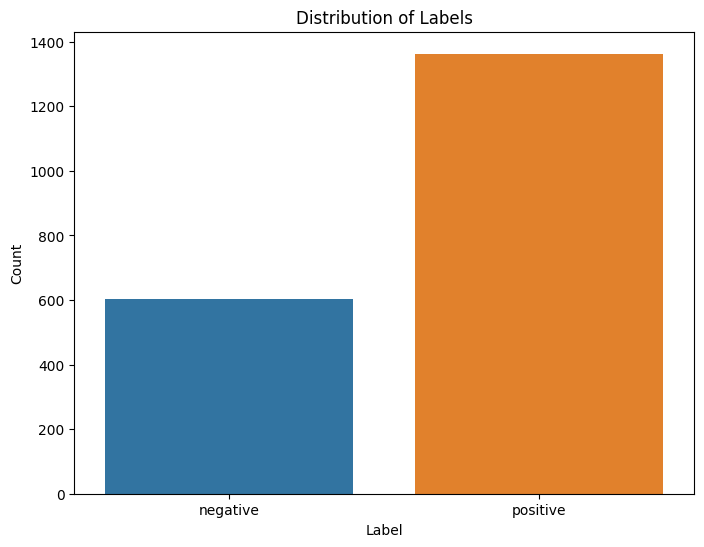

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Membuat plot distribusi kolom 'label'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [5]:
from bs4 import BeautifulSoup
import re
import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

indonesian_stopwords = set(stopwords.words('indonesian'))

def stopwords_removal(words, language):
    if language == 'english':
        list_stopwords = nltk.corpus.stopwords.words('english')
    elif language == 'indonesian':
        list_stopwords = indonesian_stopwords
    return [word for word in words if word not in list_stopwords]


def pre_process_text(text, language):
    # Case folding
    text = text.lower()
    # Remove special characters and whitespaces
    text = strip_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I | re.A)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    # Tokenize
    text = word_tokenize(text)
    # Filtering
    text = stopwords_removal(text, language)
    return " ".join(text)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df['en_text'] = df['en_text'].apply(lambda x: pre_process_text(x, 'english'))
df['id_text'] = df['id_text'].apply(lambda x: pre_process_text(x, 'indonesian'))

In [7]:
df.head()

,label,en_text,id_text
1,negative,international electronic industry company elco...,perusahaan industri elektronik internasional e...
2,positive,new production plant company would increase ca...,pabrik produksi perusahaan meningkatkan kapasi...
3,positive,according company updated strategy years 20092...,sesuai strategi terbaru perusahaan 20092012 ba...
4,positive,financing aspocomp growth aspocomp aggressivel...,pembiayaan pertumbuhan aspocomp aspocomp agres...
5,positive,last quarter 2010 componenta net sales doubled...,kuartal 2010 penjualan bersih componenta berli...


In [8]:
from sklearn.utils import resample

data_majority = df[df['label'] == "positive"]
data_minority = df[df['label'] == "negative"]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)


data_minority_upsampled = resample(data_minority,
                                 replace=True,
                                 n_samples= data_majority.shape[0],
                                 random_state=123)

df_balance = pd.concat([data_majority, data_minority_upsampled])

print("After upsampling\n",df_balance.label.value_counts(),sep = "")

majority class before upsample: (1363, 3)
minority class before upsample: (604, 3)
After upsampling
positive    1363
negative    1363
Name: label, dtype: int64


In [9]:
# Data Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.en_text, df.label, test_size=0.2, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((1573,), (394,), (1573,), (394,))

In [10]:
# Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

token = Tokenizer()
token.fit_on_texts(X_train)

In [11]:
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))

Vocabulary size=5350
Number of Documents=1573


In [12]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

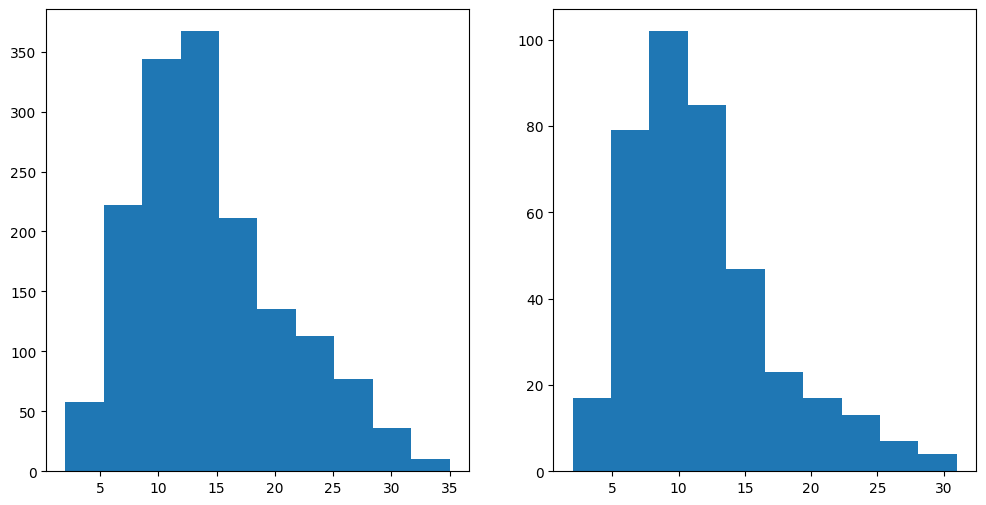

In [13]:
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#padding
MAX_SEQUENCE_LENGTH = 30
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_train.shape, X_test.shape

((1573, 30), (394, 30))

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2

In [16]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [17]:
#  Modelling

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

vector_size = 300
model = Sequential()
model.add(Embedding(vocab, vector_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(64,8, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation="relu"))
model.add(Dropout(0.1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           1605300   
                                                                 
 conv1d (Conv1D)             (None, 23, 64)            153664    
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 64)            0         
                                                                 
 dense (Dense)               (None, 11, 8)             520       
                                                                 
 dropout_1 (Dropout)         (None, 11, 8)             0         
                                                        

In [18]:
from random import shuffle
#  tarining,
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

epochs = 100
batch_size = 4

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model_cnn1d', monitor='val_accuracy', mode = 'max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/100
353/354 [============================>.] - ETA: 0s - loss: 0.6922 - accuracy: 0.5744
Epoch 1: val_accuracy improved from -inf to 0.74051, saving model to ./best_model_cnn1d
354/354 [==============================] - 25s 57ms/step - loss: 0.6923 - accuracy: 0.5739 - val_loss: 0.6804 - val_accuracy: 0.7405
Epoch 2/100
352/354 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.7060
Epoch 2: val_accuracy improved from 0.74051 to 0.74684, saving model to ./best_model_cnn1d
354/354 [==============================] - 11s 32ms/step - loss: 0.6757 - accuracy: 0.7053 - val_loss: 0.6670 - val_accuracy: 0.7468
Epoch 3/100
354/354 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7357
Epoch 3: val_accuracy did not improve from 0.74684
354/354 [==============================] - 10s 28ms/step - loss: 0.6565 - accuracy: 0.7357 - val_loss: 0.6468 - val_accuracy: 0.7468
Epoch 4/100
354/354 [==============================] - ETA: 0s - loss: 0.6184 - 

In [19]:
# Evaluation

from keras.models import load_model

saved_model = load_model('./best_model_cnn1d')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

13/13 [==============================] - 0s 7ms/step - loss: 0.4964 - accuracy: 0.7919
Train: 97.14%, Test: 79.19%


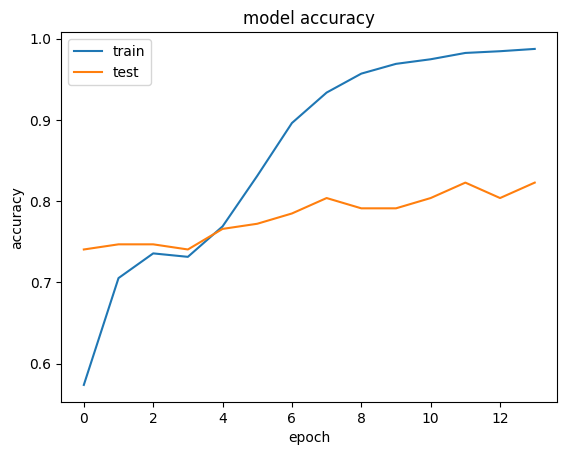

In [20]:
# Identifikasi Overfitting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

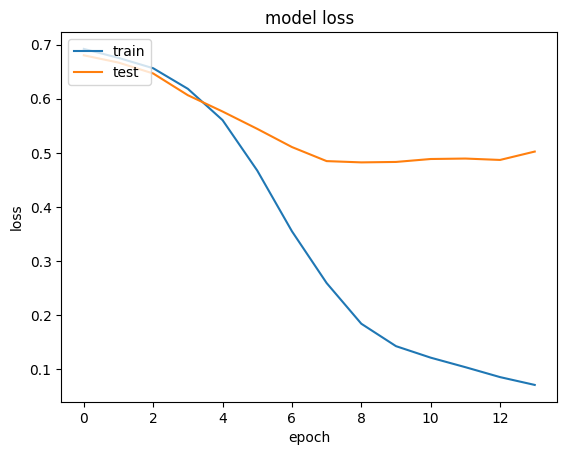

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()